## <center> Image Classification </center> 
### <center> ADS Minor Open Program </center> 

The purpose of this notebook is to serve as Open Program for the ADS Minor at Fontys University of Applied Sciences. I have applied the Machine Learning techniques SVM, Logistic Regression RFC on a preliminary exercise (SportsPersonClassifier) which can also be found on my Github.

The dataset to be used is from Kaggle (https://www.kaggle.com/fatiimaezzahra/famous-iconic-women) and contains images of 64 Iconic Women in History. Each woman has their own sub-folder in the data folder with their name as the name of the sub-folder. Face detection will be performed at first. Next, image classification with the above-mentioned methods is done. Finally, the model is saved.

Additionally, a second method will be used - CNN to see if the results obtained are better.

### 1. Imports

In [1]:
import os
import cv2
import glob
import pywt
import shutil

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib
from matplotlib import pyplot as plt

import json
import joblib 

from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
 
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 2. Preprocessing

#### 2.1. Detect face and eyes

When we look at any image, most of the time we identify a person by the face features. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in tbe pre-processing pipeline is to detect faces from an image. Once face is detected, the eyes are detected (if 2 eyes are detected, then the image is kept otherwise it is discarded).

Haar cascade from opencv: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar & https://docs.opencv.org/4.5.3/d2/d99/tutorial_js_face_detection.html

In [11]:
# detect face and eyes
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

array([[356,  37, 233, 233]], dtype=int32)

In [16]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

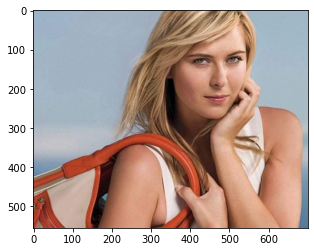

In [19]:
img = cv2.imread('./test_images/sharapova1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

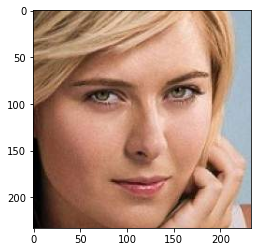

In [22]:
cropped_img = get_cropped_image_if_2_eyes('./test_images/sharapova1.jpg')
cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_img)

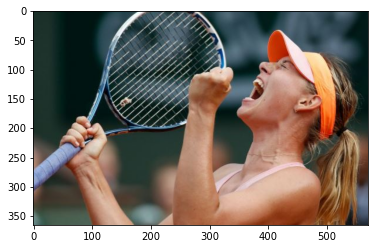

In [23]:
# an image with no 2 eyes visible on it
org_image_obstructed = cv2.imread('./test_images/sharapova2.jpg')
org_image_obstructed = cv2.cvtColor(org_image_obstructed, cv2.COLOR_BGR2RGB)
plt.imshow(org_image_obstructed)

In [24]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/sharapova2.jpg')
cropped_image_no_2_eyes

In [37]:
path_to_data = "./output/train/"
path_to_cr_data = "./output/train/_cropped/"

In [38]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [39]:
img_dirs

['./output/train/Ada Lovelace',
 './output/train/Alice Milliat',
 './output/train/Amelia Earhart',
 './output/train/Amrita Priam',
 './output/train/Angela Burdett-Coutts',
 './output/train/Angela Merkel',
 './output/train/Anna Akhmatova',
 './output/train/Aretha Franklin',
 './output/train/Audrey Hepburn',
 './output/train/Bessie Coleman',
 './output/train/Bette Davis',
 './output/train/Betty White',
 './output/train/Buchi Emecheta',
 './output/train/Celine Dion',
 './output/train/Cher',
 './output/train/Coco Chanel',
 './output/train/Diana Ross',
 './output/train/Diana, Princess of Wales',
 './output/train/Emmeline Pankhurst',
 './output/train/Estee Lauder',
 './output/train/Florence Nightingale',
 './output/train/Frida Kahlo',
 './output/train/Grace Hopper',
 './output/train/Jacinda Ardern',
 './output/train/Joan Robinson',
 './output/train/Judy Garland',
 './output/train/Junko Tabei',
 './output/train/Kamala Harris',
 './output/train/Katharine Graham',
 './output/train/Katharine Hep

In [40]:
# create folders of the women
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [41]:
# creating folders for the cropped images per woman
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./output/train/_cropped/Ada Lovelace
Generating cropped images in folder:  ./output/train/_cropped/Alice Milliat
Generating cropped images in folder:  ./output/train/_cropped/Amelia Earhart
Generating cropped images in folder:  ./output/train/_cropped/Amrita Priam
Generating cropped images in folder:  ./output/train/_cropped/Angela Burdett-Coutts
Generating cropped images in folder:  ./output/train/_cropped/Angela Merkel
Generating cropped images in folder:  ./output/train/_cropped/Anna Akhmatova
Generating cropped images in folder:  ./output/train/_cropped/Aretha Franklin
Generating cropped images in folder:  ./output/train/_cropped/Audrey Hepburn
Generating cropped images in folder:  ./output/train/_cropped/Bessie Coleman
Generating cropped images in folder:  ./output/train/_cropped/Bette Davis
Generating cropped images in folder:  ./output/train/_cropped/Betty White
Generating cropped images in folder:  ./output/train/_cropped/Buchi Emecheta
Gen

In [42]:
# saving the cropped images
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Ada Lovelace': ['./output/train/_cropped/Ada Lovelace\\Ada Lovelace1.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace10.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace11.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace12.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace13.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace14.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace15.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace16.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace17.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace18.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace19.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace2.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace20.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace21.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace22.png',
  './output/train/_cropped/Ada Lovelace\\Ada Lovelace23.

In [43]:
# dictionary for the women
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Ada Lovelace': 0,
 'Alice Milliat': 1,
 'Amelia Earhart': 2,
 'Amrita Priam': 3,
 'Angela Burdett-Coutts': 4,
 'Angela Merkel': 5,
 'Anna Akhmatova': 6,
 'Aretha Franklin': 7,
 'Audrey Hepburn': 8,
 'Bessie Coleman': 9,
 'Bette Davis': 10,
 'Betty White': 11,
 'Buchi Emecheta': 12,
 'Celine Dion': 13,
 'Cher': 14,
 'Coco Chanel': 15,
 'Diana Ross': 16,
 'Diana, Princess of Wales': 17,
 'Emmeline Pankhurst': 18,
 'Estee Lauder': 19,
 'Florence Nightingale': 20,
 'Frida Kahlo': 21,
 'Grace Hopper': 22,
 'Jacinda Ardern': 23,
 'Joan Robinson': 24,
 'Judy Garland': 25,
 'Junko Tabei': 26,
 'Kamala Harris': 27,
 'Katharine Graham': 28,
 'Katharine Hepburn': 29,
 'Katia Krafft': 30,
 'Lise Meitner': 31,
 'Madonna': 32,
 'Margaret Thatcher': 33,
 'Marie Curie': 34,
 'Marie Stopes': 35,
 'Marie Van Brittan Brown': 36,
 'Marilyn Monroe': 37,
 'Mary Wollstonecraft': 38,
 'Maryam Mirzakhani': 39,
 'Meryl Streep': 40,
 'Nancy Pelosi': 41,
 'Nina Simone': 42,
 'Oprah Winfrey': 43,
 'Rachael Heyho

#### 2.2. Wavelet transform as a feature for traning the model

In wavelet transformed image, the edges can be seen clearly, which give clues on various facial features such as eyes, nose, lips, etc.

In [45]:
def w2d(img, mode='haar', level=1):
    imArray = img
   
    # convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY)
    
    # convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    # process coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

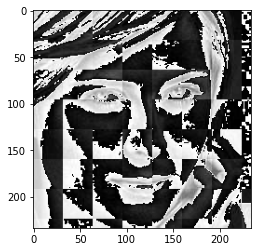

In [46]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

Images in the cropped folders can be used for model training. These raw images are used along with wavelet transformed images to train our classifier.

#### 2.3. Prepare X and y

In [47]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [48]:
len(X[0])

4096

In [49]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(1641, 4096)

Data cleaning process is done. The model is ready to be trained -> SVM with rbf kernel tuned with heuristic finetuning

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6058394160583942

In [51]:
len(X_test)

411

GridSearch is used now to try out different models with different paramets. The goal is to come up with best model with the best fine tuned parameters.

In [52]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [53]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=2, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.513008,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.250407,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.484553,{'logisticregression__C': 1}


In [54]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [55]:
best_estimators['svm'].score(X_test,y_test)

0.6666666666666666

In [56]:
best_estimators['random_forest'].score(X_test,y_test)

0.3236009732360097

In [57]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.5815085158150851

In [58]:
best_clf = best_estimators['svm']

In [59]:
cm = confusion_matrix(y_true = y_test, y_pred = best_clf.predict(X_test))

In [60]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [61]:
cm_plot_labels = ['Ada Lovelace', 'Alice Milliat', 'Amelia Earhart', 'Amrita Priam', 'Angela Burdett-Coutts', 'Angela Merkel', 'Anna Akhmatova',
                  'Aretha Franklin', 'Audrey Hepburn', 'Bessie Coleman', 'Bette Davis', 'Betty White', 'Buchi Emecheta', 'Celine Dion', 'Cher', 'Coco Chanel',
                  'Diana Ross', 'Diana, Princess of Wales', 'Emmeline Pankhurst', 'Florence Nightingale', 'Frida Kahlo', 'Gertrude Ederle', 'Grace Hopper',
                  'Jacinda Ardern', 'Joan Robinson', 'Judy Garland', 'Junko Tabei', 'Kamala Harris', 'Katharine Graham', 'Katharine Hepburn', 'Katia Krafft',
                  'Lise Meitner', 'Madonna', 'Margaret Thatcher', 'Marie Curie', 'Marie Stopes', 'Marie Van Brittan Brown', 'Marilyn Monroe', 'Mary Wollstonecraft',
                  'Maryam Mirzakhani', 'Meryl Streep', 'Nancy Pelosi', 'Nina Simone', 'Oprah Winfrey', 'Rachael Heyhoe Flint', 'Raja Easa Al Gurg', 'Rihanna',
                  'Rosa Parks', 'Ruth Handler', 'Serena Williams', 'Sheryl Sandberg', 'Simone de Beauvoir', 'Sirimavo Bandaranaike', 'Sonja Henie',
                  'Susan Sontag', 'Suzanne Lenglen', 'Vera Atkins', 'Virginia Woolf', 'Wangari Maathai', 'Whitney Houston', 'Wilma Rudolph', 'Zora Neale Hurston']

Confusion matrix, without normalization
[[11  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  5 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]


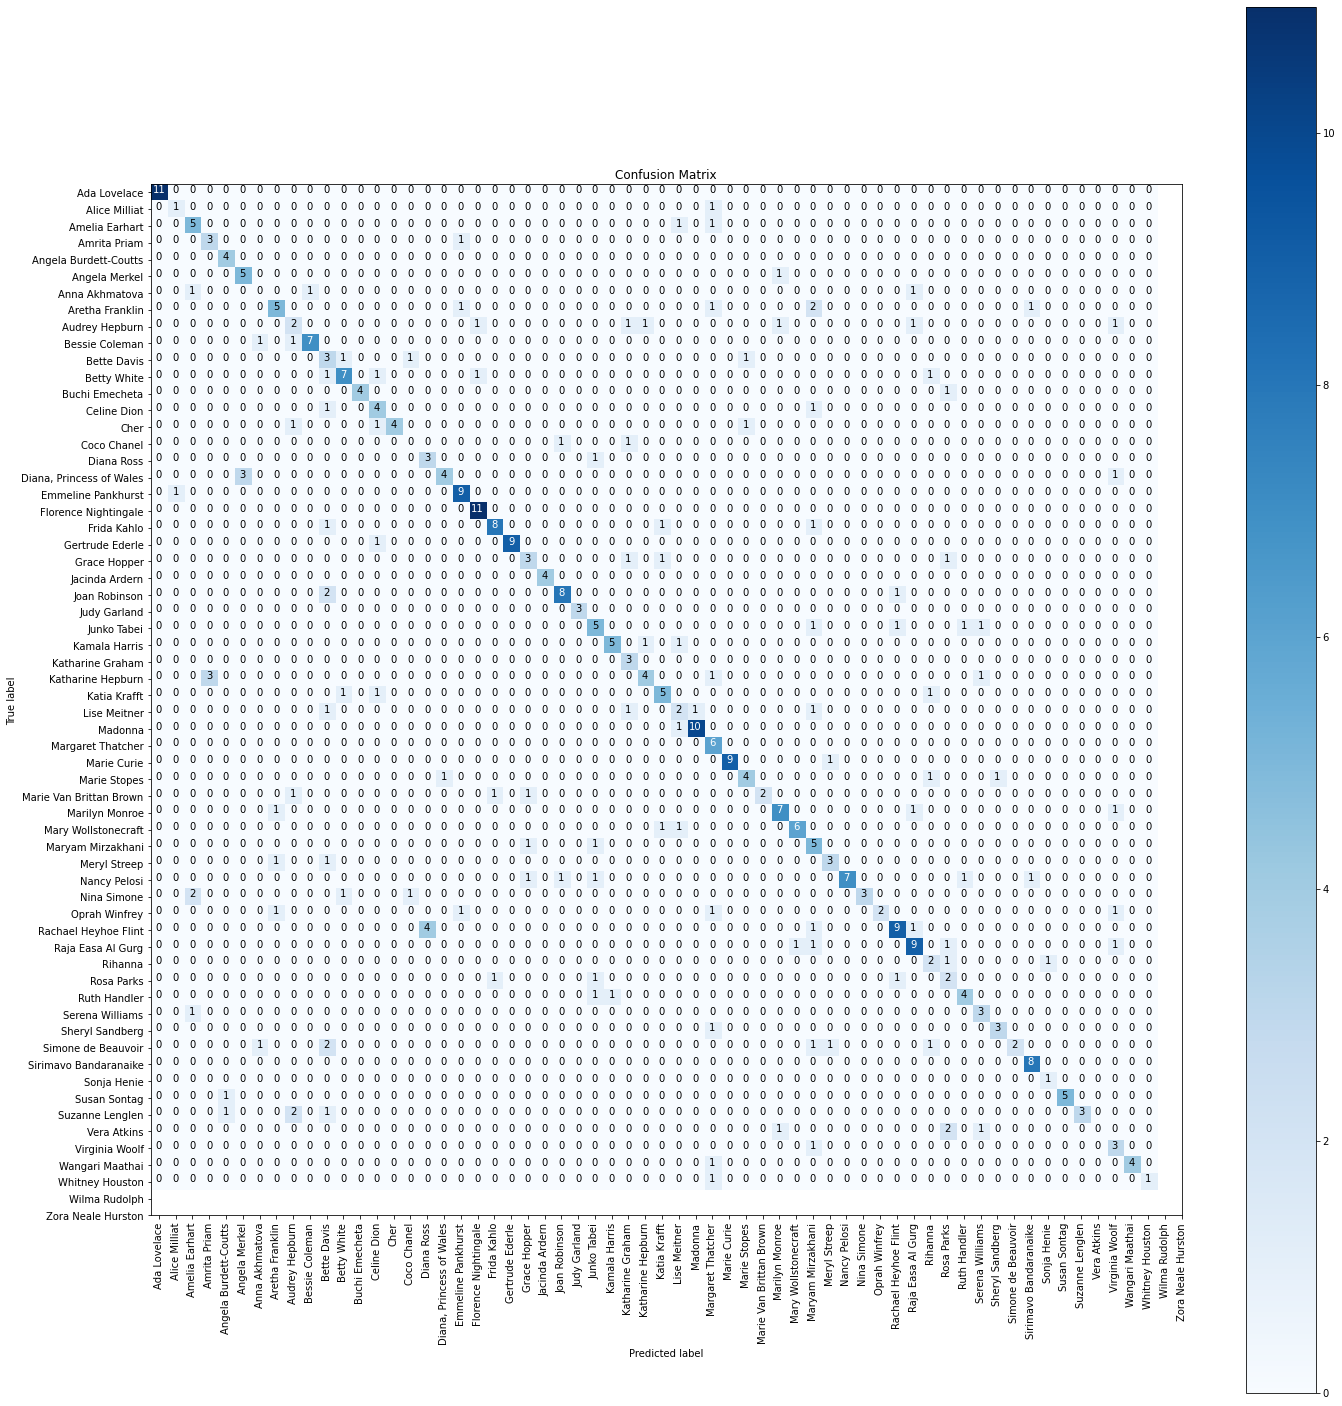

In [62]:
import itertools
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### 3. Save the model

In [63]:
#!pip install joblib

#### 3.1. Save the model as a pickle in a file 

In [64]:
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

#### 3.2. Save the class dictionary

In [65]:
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

### 4. CNN

In [66]:
# check for UnidentifiedImageError
import PIL
from PIL import UnidentifiedImageError
import glob

imgs_ = glob.glob("./output/train/*/*.jpg")

for img in imgs_:
    try:
        img = PIL.Image.open(img)
    except PIL.UnidentifiedImageError:
        print(img)

In [115]:
data = './output/_cropped'

In [116]:
file_pathAll = list(glob.glob(data+'/**/*.png'))
labels = list(map(lambda x :os.path.split(os.path.split(x)[0])[1], file_pathAll))
file_path = pd.Series(file_pathAll, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Filepath,Label
0,./output/_cropped\Joan Robinson\Joan Robinson1...,Joan Robinson
1,./output/_cropped\Betty White\Betty White17.png,Betty White
2,./output/_cropped\Sheryl Sandberg\Sheryl Sandb...,Sheryl Sandberg
3,./output/_cropped\Rihanna\Rihanna17.png,Rihanna
4,./output/_cropped\Cher\Cher30.png,Cher


In [93]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)

#### Functions

In [96]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [106]:
def func(name_model):
    pre_model = name_model(
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(600, activation='relu')(pre_model.output)
    x = Dense(600, activation='relu')(x)
    outputs = Dense(62, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              patience=5,
                              min_delta=0,
                              mode='auto')]
    return model, my_callbacks

In [107]:
def plot_acc_loss(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()
    return history

In [108]:
def predict_on_test(history,test_gen,train_gen,model):
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    return history

In [109]:
def cm(history,test_gen,train_gen,model):
    cm=confusion_matrix(test_df.Label,pred)
    clr = classification_report(test_df.Label, pred)
    print(clr)
    return history

In [110]:
def evaluate(history,test_gen,train_gen,model):
# Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8),
                             subplot_kw={'xticks': [], 'yticks': []})
    
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.Filepath.iloc[i+1]))
        ax.set_title(f"True: {test_df.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    return history

In [111]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df, test_df)

Found 1634 validated image filenames belonging to 62 classes.
Found 408 validated image filenames belonging to 62 classes.
Found 511 validated image filenames belonging to 62 classes.


In [112]:
ResNet50_model, callback=func(ResNet50)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [113]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=10,
    callbacks=callback
)

Epoch 1/10
52/52 [==============================] - 197s 4s/step - loss: 3.3381 - accuracy: 0.2271 - val_loss: 2.5105 - val_accuracy: 0.3799
Epoch 2/10
52/52 [==============================] - 210s 4s/step - loss: 1.5418 - accuracy: 0.5955 - val_loss: 2.0507 - val_accuracy: 0.4926
Epoch 3/10
52/52 [==============================] - 199s 4s/step - loss: 0.7595 - accuracy: 0.7962 - val_loss: 1.7629 - val_accuracy: 0.5711
Epoch 4/10
52/52 [==============================] - 223s 4s/step - loss: 0.3881 - accuracy: 0.8947 - val_loss: 1.7867 - val_accuracy: 0.5980
Epoch 5/10
52/52 [==============================] - 260s 5s/step - loss: 0.1663 - accuracy: 0.9590 - val_loss: 1.8300 - val_accuracy: 0.5907
Epoch 6/10
52/52 [==============================] - 205s 4s/step - loss: 0.0914 - accuracy: 0.9798 - val_loss: 1.8148 - val_accuracy: 0.6078
Epoch 7/10
52/52 [==============================] - 209s 4s/step - loss: 0.0314 - accuracy: 0.9976 - val_loss: 1.7965 - val_accuracy: 0.6446
Epoch 8/10
11

KeyboardInterrupt: 

In [ ]:
#### densenet201
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = gen(DenseNet201_pre,train_df, test_df)

In [ ]:
DenseNet201_model, callback=func(DenseNet201)

In [ ]:
history_DenseNet201 = DenseNet201_model.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    callbacks=callback)

In [ ]:
history_DenseNet201=plot(history,test_gen_DenseNet201,train_gen_DenseNet201,DenseNet201_model)

In [ ]:
result_DenseNet201 = result_test(test_gen_DenseNet201,DenseNet201_model)